# Neural Network Trainings

_Author: Aline Van Driessche_

This notebook contains all code needed to perform Neural Network trainings (1D and 2D) on individual latitude information available from ECCO. Read section headings for more details on setup, preprocessing, and model training.

# Setup

Importing relevant modules and custom scripts. A number of helper functions are also defined to clean up experiment code.

In [2]:
import sys
import pandas as pd

import config
import paths
import pickle

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
from sklearn.metrics import *
from typing import Union
from models import train, CNN1D, CNN2D

import matplotlib.pyplot as plt

In [3]:
# A helper function to subset 30S, since the satellite observable variables do not always exist for all longitudes - the values are taken from an earlier defined basin function
def mask_30S(inputs):
    mask = np.logical_or(np.logical_or(np.logical_and(inputs.longitude >= -180, 
                                                      inputs.longitude <= -71),
                                       np.logical_and(inputs.longitude >= 31, 
                                                      inputs.longitude <= 115)),
                         np.logical_and(inputs.longitude >= 153, 
                                        inputs.longitude <= 180))
    masked = inputs.where(mask, drop = True)

    return masked

In [4]:
# Helper function to align the in-and outputs of two datasets with the inputs
def align_dates(inputs, outputs):

    # Align the dates according to the data available for in- and output
    date_range = (inputs.time.values[0], inputs.time.values[-1]) # grabbing start and end date for inputs
    date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
    print('Date range to align to:', date_range)
    return align_inputs_outputs(inputs, outputs, date_range = date_range, ecco=False)

In [5]:
# A helper function to format the input files based on a given latitude
def format_lat_lon(value):
    """Format latitude or longitude with N/S or E/W suffix."""
    if value < 0:
        return f"{abs(value)}S"
    else:
        return f"{value}N"

## Experiment Variables

All variables that might be worth changing during experiments. Of particular interest is `no_zonal_averages` and `zonal_avgs` which controls which variables are averaged zonally and which variables are left with all longitudinal information.

In [6]:
data_home = paths.LOCAL_DIR
lats = [26, -30, -55, -60]

lat = lats[3]

zonal_avg = ['time']
no_zonal_avgs = ['time', 'longitude']   #for 2D training this setting is necessary

remove_season = False
remove_trend = False

input_vars = ['OBP', 'ZWS', 'SST'] #other options are 'SSH', 'SSS', 'SST'

timelag=6

inputs_fp = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}.nc"
outputs_fp = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}_moc_density.pickle"

# HYPERPARAMETERS
dropout = 0.1
n_pure_layers = 1
n_mix_layers = 2
n_channels_mult = 5
kernel_size = 3          #For 2D input change this to (3x3)
model_iterations = 3

## Loading and processing relevant data
Data loading function that extracted and preprocesses the data as defined in the “Experiment Variables” section and returns the in- and output for training.  

In [7]:
# To reduce computational complexity when training models, load in- and output datasets only once 
inputs = xr.open_dataset(inputs_fp).isel(latitude=slice(1,2)) #ecco satellite observable variables
with open(outputs_fp, 'rb') as f:
    outputs = pickle.load(f).astype(np.float64)

In [8]:
def retrieve_data(lat=lat, inputs:Union[str, xr.Dataset]=inputs, outputs:Union[str, xr.Dataset]=outputs, timelag=timelag, coords = zonal_avg, input_vars=input_vars, remove_trend=remove_trend, remove_season=remove_season, verbose=False):
    
    if isinstance(inputs, str):
        inputs = xr.open_dataset(inputs).isel(latitude=slice(1,2))
    if isinstance(outputs, str):
        with open(outputs, 'rb') as f:
            outputs = pickle.load(f).astype(np.float64)

    # Some latitudes need specific preprocessing because of missing data or land that will obstruct training
    if lat == -30:
        inputs = mask_30S(inputs) 
    if lat == -55:
        inputs = inputs.dropna('longitude', how = 'all')
        
    # Retrieve the output streamfunctions to train on (in density space), this file contains the latitude right above and right below so we take the middle one
    outputs = np.expand_dims(outputs, 1) # grabbing just the middle latitude of interest 

    # Convert the data to an xarray dataset structure similar to the input data
    outputs = xr.Dataset(
                data_vars = {'moc' : (["time", "latitude"], outputs)}, 
                coords = {'time' : inputs.time, 'latitude' : np.atleast_1d(lat),}
            )
    
    # Align the date ranges
    inputs, outputs = align_inputs_outputs(inputs, outputs, ecco=False)
    
    # Input data preprocessing (standardize)
    pp_data_surface = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=remove_season,
                              remove_trend=remove_trend,
                              standardize=True,
                              lowpass=False)
    X = reshape_inputs(pp_data_surface, history=timelag, keep_coords=coords, data_vars=input_vars, verbose=verbose)
    
    # Necessary transpose for convolutions with PyTorch Tensors + adjusting the shape to suit as CNN input
    dims = list(range(X.ndim))  
    dims[1], dims[-1] = dims[-1], dims[1]
    X = np.transpose(X, dims)
    if len(X.shape) == 2:
        X = np.expand_dims(X, axis=-1)
    
    # MOC strength preprocessing (don't standardize)
    strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=remove_season,
                               remove_trend=remove_trend,
                               standardize=False,
                               lowpass=False)
    strength_np = strength.moc.squeeze().values
    
    # If the history parameter changed the input shape, change the outputs accordingly
    y = strength_np[-X.shape[0]:]
    
    if verbose is not False:
        print()
        print('Inputs shape:', X.shape)
        print('Outputs shape:', y.shape)
    return X, y

In [9]:
X, y = retrieve_data(verbose=True)

axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS', 'SST']
shape: (283, 6, 3)

Inputs shape: (283, 3, 6)
Outputs shape: (283,)


## Running Experiments

Data is extracted and preprocessed as defined in the "Experiment Variables" section. We perform a neural network training using the hyperparameters as described above. The paper outlines which metrics generate the best performances for each latitude. Our five metrics (RMSE, MAE, MAPE, $R^2$, correlation) are then calculated.

In [10]:
# Training setup (to be used in experiments below)
def train_CNN(X, y, type='1DCNN'):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, stratify=None, random_state=123456)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=False, stratify=None, random_state=123456)

    device = "cuda" if t.cuda.is_available() else "cpu"

    Xt_train = t.tensor(X_train, device=device)
    Yt_train = t.tensor(y_train, device=device)
    Xt_valid = t.tensor(X_valid, device=device).double()
    Yt_valid = t.tensor(y_valid, device=device).double()
    Xt_test = t.tensor(X_test, device=device).double()
    Yt_test = t.tensor(y_test, device=device).double()

    if type == '1DCNN':
        model = CNN1D.CNN1D(
            n_pure_layers=n_pure_layers, 
            n_mix_layers=n_mix_layers, 
            n_features=Xt_train.shape[1], 
            n_channels=Xt_train.shape[1]*n_channels_mult,
            kernel_size=kernel_size,
            dropout=dropout, 
        ).double()
    elif type == '2DCNN':
        model = CNN2D.CNN2D(
            n_pure_layers=n_pure_layers, 
            n_mix_layers=n_mix_layers, 
            n_features=Xt_train.shape[1], 
            n_channels=Xt_train.shape[1]*n_channels_mult,
            kernel_size=(kernel_size,kernel_size),
            dropout=dropout, 
        ).double()

    model, train_loss, val_loss = train.train_model( 
        model=model, 
        dtype='double',
        X_train = Xt_train, 
        y_train = Yt_train, 
        X_val = Xt_valid,
        y_val = Yt_valid, 
        early_stopping=True,
        min_delta=0.01, 
        threshold=5
    )
    
    # Extracting all predictions in time order
    train_set_pred = train.predict(model, Xt_train, Yt_train)
    valid_set_pred = train.predict(model, Xt_valid, Yt_valid)
    test_set_pred = train.predict(model, Xt_test, Yt_test)
    
    predictions = {
        "train_set_pred": train_set_pred, 
        "valid_set_pred": valid_set_pred, 
        "test_set_pred": test_set_pred, 
        "all_preds": np.concatenate([train_set_pred, valid_set_pred, test_set_pred])
    }
    
    metrics = {
        "rmse": round(root_mean_squared_error(test_set_pred, y_test), 3),
        "mae": round(mean_absolute_error(test_set_pred, y_test), 3),
        "mape": round(mean_absolute_percentage_error(test_set_pred, y_test), 3)*100,        
        "cmape": round(custom_MAPE(np.array(test_set_pred).squeeze(), y_test, threshold=0.5), 3)*100,
        "test_corr": round(np.corrcoef(np.array(test_set_pred).squeeze(), y_test)[0, 1], 3),
        }
    
    return metrics, predictions

#### Experiment 1. 
Running 1 2D-CNN model with the parameters as explained in the "Experiment variables" section

In [269]:
# Run the prediction with the given input values
X, y = retrieve_data(coords=no_zonal_avgs)
metrics, predictions = train_CNN(X, y, type='2DCNN')

device: cpu
2731 parameters.


100%|██████████| 5000/5000 [40:40<00:00,  2.05it/s]  


test set (57,)
(57,)


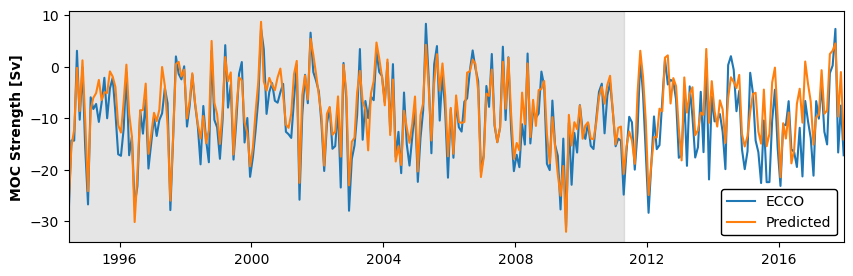

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, stratify=None, random_state=123456)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=False, stratify=None, random_state=123456)

time = inputs.time.values[-X.shape[0]:]
fig, ax = timeseries_comparison(predictions['all_preds'], y, time, len(X_train))
plt.show()

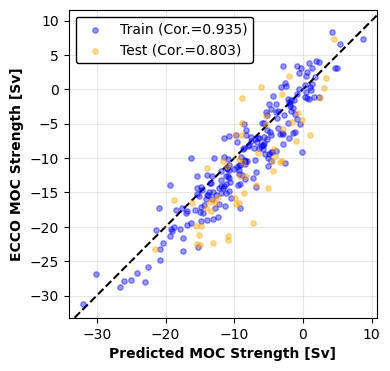

In [271]:
# Alternate view: looking at a scatterplot of predicted vs. actual
y_pred_train = np.array(predictions['train_set_pred']).squeeze()
y_pred_test = np.array(predictions['test_set_pred']).squeeze()

fig, ax = pred_vs_actual(y_pred_train, y_pred_test, y_train, y_test)
plt.show()

#### Experiment 2. 

Running a similar model (here a 1D-CNN) multiple times with the parameters as explained in the "Experiment variables" section to assess the variability and influence of initialisation weights and biases. Here run as an example on a 1D-CNN. 

In [184]:
metrics_models = []
predictions_models = []

for i in range(model_iterations):
    X, y = retrieve_data()
    metrics, predictions = train_CNN(X, y)
    metrics_models.append(metrics)
    predictions_models.append(predictions)

metrics_df = pd.DataFrame(metrics_models)
predictions_df = pd.DataFrame(predictions_models)

summary_metrics_df = pd.DataFrame({
                "mean": metrics_df.mean().round(3), 
                "std": metrics_df.std().round(3)}
            )
display(summary_metrics_df)

device: cpu
353 parameters.


100%|██████████| 5000/5000 [00:24<00:00, 205.54it/s]


test set (58, 1)
(58,)
device: cpu
353 parameters.


100%|██████████| 5000/5000 [00:31<00:00, 159.68it/s]


test set (58, 1)
(58,)
device: cpu
353 parameters.


100%|██████████| 5000/5000 [00:31<00:00, 159.05it/s]


test set (58, 1)
(58,)


,mean,std
rmse,4.298,0.064
mae,3.489,0.070
mape,67.333,6.562
cmape,55.433,2.380
test_corr,0.894,0.005


#### Experiment 3. 

Running the same model multiple times with varying timelags to assess their performances based on that value. We here train one test case to show how the timelag variation works, if we would save these files for various latitudes we can obtain the result displayed below.

In [ ]:
metrics_models = []
predictions_models = []

timelag_iterations = 12

for i in range(timelag_iterations):
    X, y = retrieve_data(timelag=timelag)
    metrics, predictions = train_CNN(X, y)
    metrics_models.append(metrics)
    predictions_models.append(predictions)

metrics_df = pd.DataFrame(metrics_models)
predictions_df = pd.DataFrame(predictions_models)
metrics_df.to_csv(f"{paths.LOCAL_DIR}/{lat}_history.csv")

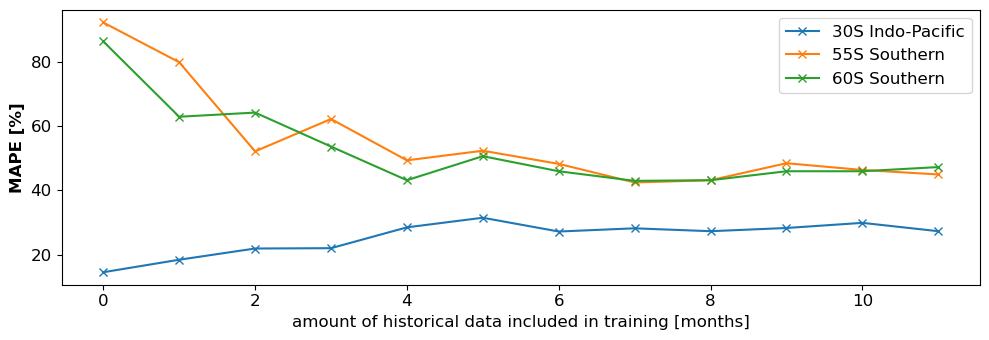

In [12]:
plot_30 = pd.read_csv(f"{paths.LOCAL_DIR}/plotting_data_aline/-30_history.csv")
plot_55 = pd.read_csv(f"{paths.LOCAL_DIR}/plotting_data_aline/-55_history.csv")
plot_60 = pd.read_csv(f"{paths.LOCAL_DIR}/plotting_data_aline/-60_history.csv")

# Plotting
plt.figure(figsize=(10, 3.5))  # Optional: specifies the figure size
plt.plot(plot_30.index, plot_30['cmape'], marker='x', linestyle='-', linewidth=1.5, label='30S Indo-Pacific')  
plt.plot(plot_55.index, plot_55['cmape'], marker='x', linestyle='-', linewidth=1.5, label='55S Southern') 
plt.plot(plot_60.index, plot_60['cmape'], marker='x', linestyle='-', linewidth=1.5, label='60S Southern') 
plt.xlabel('amount of historical data included in training [months]', fontsize=12)
plt.ylabel('MAPE [%]', fontsize=12, weight="bold")
plt.legend(fontsize=12) 
plt.tick_params(labelsize=12)
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.savefig(f"C:/Users/aline/OTP/plots/history1DCNN.png", dpi=400)
plt.show()

#### Experiment 4. 

Running the same model on various latitudes to compare their performances. Important to note that here we have to load a separate dataset for each run, whereas above we always relied on the same input- and output dataset. The resulting prediction and groundtruth timeseries are plotted together for each of the latitudes. 

In [15]:
predictions_models = []
ground_truths = []

for lat in lats:
    
    inputs_fp = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}.nc"
    outputs_fp = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}_moc_density.pickle"
    
    X, y = retrieve_data(lat=lat, inputs=inputs_fp, outputs=outputs_fp)
    metrics, predictions = train_CNN(X, y)
    ground_truths.append(y)
    predictions_models.append(predictions)

device: cpu
1021 parameters.


100%|██████████| 2500/2500 [00:22<00:00, 112.26it/s]


device: cpu
1021 parameters.


100%|██████████| 2500/2500 [00:27<00:00, 89.71it/s] 


device: cpu
1021 parameters.


100%|██████████| 2500/2500 [00:26<00:00, 93.38it/s] 


device: cpu
1021 parameters.


100%|██████████| 2500/2500 [00:27<00:00, 90.87it/s] 


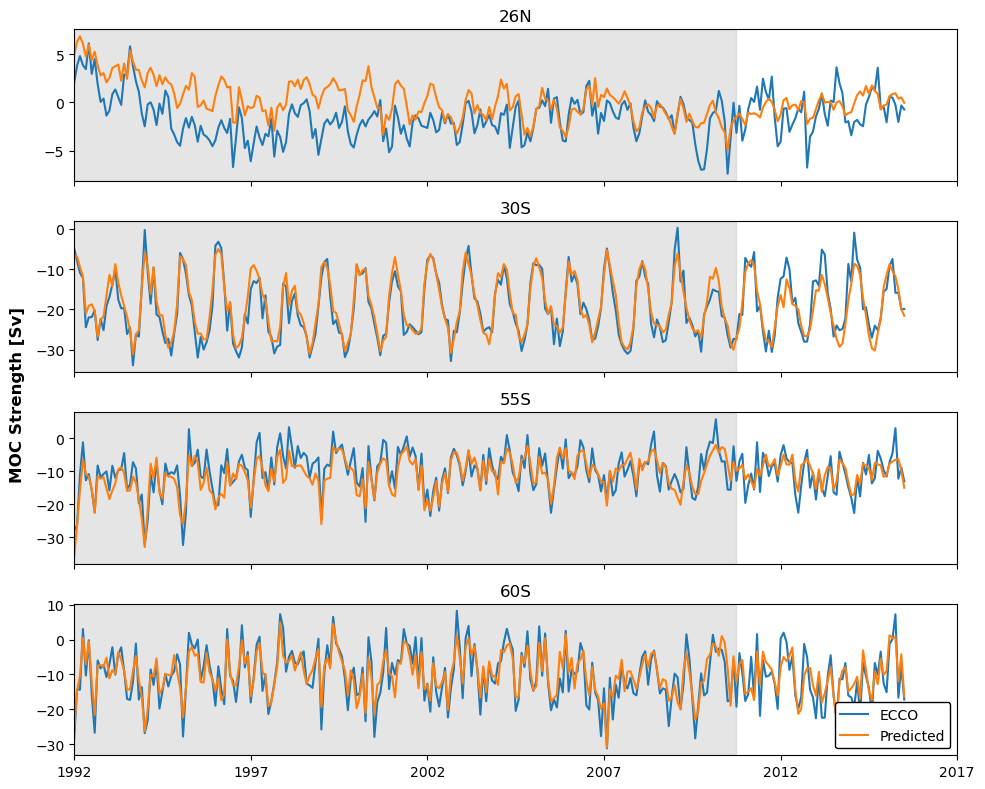

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, stratify=None, random_state=123456)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=False, stratify=None, random_state=123456)

fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, squeeze=True, figsize=(10, 8))
sections = [format_lat_lon(lat) for lat in lats]

for index, ax in enumerate(axs):
    
    moc = ground_truths[index]
    full_pred = predictions_models[index]['all_preds']
    section = sections[index]
    
    ax.plot(moc, label="ECCO")
    ax.plot(full_pred, label="Predicted")
    y_lower, y_upper = ax.get_ylim()
    x_pos = np.arange(len(X) - len(X_test))
    ax.fill_between(x = x_pos, 
                    y1 = np.repeat(y_lower, len(x_pos)), 
                    y2 = np.repeat(y_upper, len(x_pos)),
                    alpha = 0.2, 
                    color = 'gray')
    ax.margins(x = 0, y = 0)
    ax.set_title(section)
ax.set_xticks(np.arange(0, 324, 60), np.arange(1992, 2019, 5))
ax.legend(loc = 'lower right', edgecolor = 'black', framealpha = 1)
fig.supylabel("MOC Strength [Sv]", weight="bold")
plt.tight_layout()
plt.savefig(f"C:/Users/aline/OTP/plots/4latspredictions.png", dpi=400)
plt.show()